## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd

In [2]:
np.set_printoptions(linewidth=150)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## open and visualise csv

In [3]:
PT_drive = '/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive'

In [4]:
df = pd.read_csv(f'{PT_drive}/df_helechos_clean.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.set_index('DateTime').sort_index()
df.head()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos
DateTime,,,,,,,,
2018-09-02 00:00:00,2018-09-02,9,245,0,4.553,100.0,0,0
2018-09-02 01:00:00,2018-09-02,9,245,1,4.051,100.0,0,0
2018-09-02 02:00:00,2018-09-02,9,245,2,4.553,100.0,0,0
2018-09-02 03:00:00,2018-09-02,9,245,3,3.550,100.0,0,0
2018-09-02 04:00:00,2018-09-02,9,245,4,3.048,100.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11303 entries, 2018-09-02 00:00:00 to 2019-12-16 23:00:00
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     11303 non-null  object 
 1   Month                    11303 non-null  int64  
 2   Day                      11303 non-null  int64  
 3   hour                     11303 non-null  int64  
 4   Temp                     11303 non-null  float64
 5   RH%                      11303 non-null  float64
 6   Gastrotheca chysosticta  11303 non-null  int64  
 7   Oreobates berdemenos     11303 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 794.7+ KB


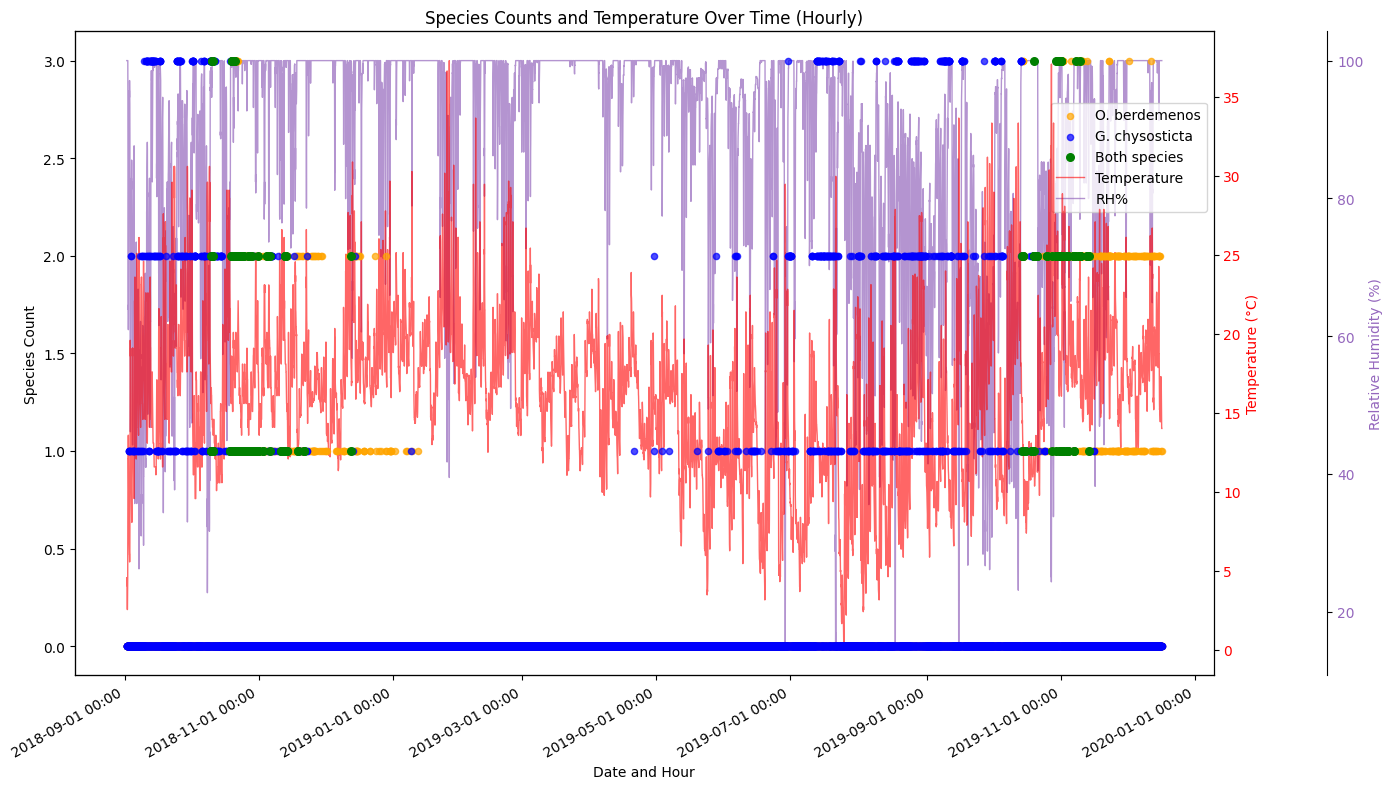

In [6]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

#df.index is the DateTime column after setting it as index, can still be accessed

# Plot species counts on primary y-axis
ax1.scatter(df.index, df['Oreobates berdemenos'], 
            color='orange', label='O. berdemenos', s=20, alpha=0.7, zorder=10)
ax1.scatter(df.index, df['Gastrotheca chysosticta'], 
            color='blue', label='G. chysosticta', s=20, alpha=0.7, zorder=20)

# Find times where both species are present in the same hour
both_species_hourly = df[
    (df['Oreobates berdemenos'] > 0) & 
    (df['Gastrotheca chysosticta'] > 0)
]

# Plot green points for hours where both species are present
if len(both_species_hourly) > 0:
    ax1.scatter(both_species_hourly.index, both_species_hourly['Oreobates berdemenos'], 
                color='green', s=30, label='Both species', zorder=30)
    ax1.scatter(both_species_hourly.index, both_species_hourly['Gastrotheca chysosticta'], 
                color='green', s=30, label='', zorder=40)
    
ax1.set_xlabel('Date and Hour')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df.index, df['Temp'], 'r-', linewidth=1, alpha=0.6, label='Temperature', zorder=5)
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Third axis for RH%
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.10))
ax3.set_ylabel('Relative Humidity (%)', color='tab:purple')
ax3.tick_params(axis='y', labelcolor='tab:purple')
ax3.plot(df.index,
         df['RH%'],
         color='tab:purple', linestyle='-', linewidth=1, alpha=0.7, label='RH%',zorder=3)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2 +lines3, labels1 + labels2+labels3, loc='upper right',bbox_to_anchor = (1,0.9))

# Desired top-to-bottom order (edit this list: first = top/front)
axes_order = ['ax1', 'ax2', 'ax3']  # e.g. ['ax3','ax1','ax2'] to put ax3 on top

def _reorder_axes(event=None):
    ax_map = {'ax1': ax1, 'ax2': ax2, 'ax3': ax3}
    # Make all axis patches transparent so lower axes are visible
    for ax in ax_map.values():
        ax.set_facecolor('none')
        ax.patch.set_alpha(0)
    # Assign zorders: higher = on top
    # Enumerate from bottom to top so last in list gets highest zorder
    for z, name in enumerate(reversed(axes_order), start=1):
        ax_map[name].set_zorder(z)

# Defer reordering until after ax2/ax3 are created later in the cell
fig.canvas.mpl_connect('draw_event', _reorder_axes)

# # Limit to a shorter time window for better visualization with hourly data
# date_max = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=515)#
# date_min = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=520)#, 81 has lots of noise
# plt.xlim(date_min, date_max)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Species Counts and Temperature Over Time (Hourly)')
plt.tight_layout()
plt.show()

# Granger Causality

In [7]:
# Granger / VAR causality test between the two species time series using no exogenous variables


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

# Granger / VAR causality test between the two species time series

if 'DateTime' not in df.columns:
    df['DateTime'] = df.index

# 1. Prepare evenly spaced hourly series (sum per hour), fill missing with 0
cols = ['Oreobates berdemenos', 'Gastrotheca chysosticta']
df_gc = (
    df[cols]
)

# 2. ADF stationarity test; difference if non–stationary (p>0.05)
def adf_stationary(series, name):
    s = series.astype(float)
    if (s.var() == 0) or (s.nunique() < 3):
        return s, False, 1.0
    p = adfuller(s, autolag='AIC')[1]
    return s, True, p

stationary_series = {}
diff_needed = {}
adf_pvals = {}
for c in cols:
    s, ok, p = adf_stationary(df_gc[c], c)
    adf_pvals[c] = p
    if p > 0.05:
        # first difference
        s_diff = s.diff().dropna()
        # Re-test (optional, not required for workflow)
        stationary_series[c] = s_diff
        diff_needed[c] = True
    else:
        stationary_series[c] = s
        diff_needed[c] = False

# Align after differencing (drop NaNs introduced by differencing)
gc_data = pd.concat(stationary_series, axis=1).dropna()

# Ensure enough data
if len(gc_data) < 30:
    raise ValueError("Not enough data after preprocessing for VAR/Granger test.")

# 3. Select VAR lag order (up to 24 hours or len/5)
maxlags = min(24, max(5, len(gc_data)//5))
order_res = VAR(gc_data).select_order(maxlags=maxlags)
lag_aic = order_res.selected_orders.get('aic')
# fallback if None
selected_lag = lag_aic if lag_aic is not None else next(v for v in order_res.selected_orders.values() if v is not None)

# Guard: lag must be >=1
if not selected_lag or selected_lag < 1:
    selected_lag = 1

# 4. Fit VAR
model = VAR(gc_data)
var_res = model.fit(selected_lag)

# 5. Causality tests (directional)
# Test: does Oreobates -> Gastrotheca?
res_OB_to_GC = var_res.test_causality('Gastrotheca chysosticta', ['Oreobates berdemenos'], kind='f')

# Test: does Gastrotheca -> Oreobates?
res_GC_to_OB = var_res.test_causality('Oreobates berdemenos', ['Gastrotheca chysosticta'], kind='f')

print("=== Data summary ===")
print(f"Rows (hourly, after differencing if applied): {len(gc_data)}")
print("ADF p-values (original series):")
for c in cols:
    print(f"  {c}: p={adf_pvals[c]:.4g}  -> differenced: {diff_needed[c]}")
print(f"\nSelected VAR lag (AIC): {selected_lag}")
print("\n=== Direction: Oreobates berdemenos -> Gastrotheca chysosticta ===")
print(f"F-test p-value: {res_OB_to_GC.pvalue:.4g}")
print(res_OB_to_GC.summary())

print("\n=== Direction: Gastrotheca chysosticta -> Oreobates berdemenos ===")
print(f"F-test p-value: {res_GC_to_OB.pvalue:.4g}")
print(res_GC_to_OB.summary())

print("\nInterpretation guide:")
print("- Low p-value (<0.05) suggests rejecting null of 'no Granger causality' in that direction.")
print("- Differencing applied where ADF indicated non-stationarity (p>0.05).")
print("- Results are on (possibly differenced) series; ecological interpretation should map back to original counts.")

/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/untitled folder/yungas_aruna/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


=== Data summary ===
Rows (hourly, after differencing if applied): 11303
ADF p-values (original series):
  Oreobates berdemenos: p=4.643e-12  -> differenced: False
  Gastrotheca chysosticta: p=1.239e-15  -> differenced: False

Selected VAR lag (AIC): 24

=== Direction: Oreobates berdemenos -> Gastrotheca chysosticta ===
F-test p-value: 0.3477
Granger causality F-test. H_0: Oreobates berdemenos does not Granger-cause Gastrotheca chysosticta. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value           df         
-----------------------------------------------------------
         1.088          1.518   0.348 (24, np.int64(22460))
-----------------------------------------------------------

=== Direction: Gastrotheca chysosticta -> Oreobates berdemenos ===
F-test p-value: 0.02894
Granger causality F-test. H_0: Gastrotheca chysosticta does not Granger-cause Oreobates berdemenos. Conclusion: reject H_0 at 5% significance level.
Test statistic Cr

/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/untitled folder/yungas_aruna/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Treat calls as ordinal, add weather, hour, day as exogenous variables

In [ ]:
# Ordered-logit "Granger" causality with exogenous controls (temp, RH, diurnal)
# Directional tests: Oreo -> Gastro and Gastro -> Oreo

import numpy as np
import pandas as pd
from itertools import product
from typing import Tuple, Dict, List

from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2


# ----------------------------
# Utilities
# ----------------------------

def add_time_features(dfh: pd.DataFrame) -> pd.DataFrame:
    """Add diurnal sin/cos based on the DateTimeIndex (hour + minute)."""
    h = dfh.index.hour + dfh.index.minute / 60.0
    day = dfh.index.dayofyear + h / 24.0
    dfh = dfh.copy()
    dfh["hour_sin"] = np.sin(2 * np.pi * h / 24.0)
    dfh["hour_cos"] = np.cos(2 * np.pi * h / 24.0)
    dfh['day_sin'] = np.sin(2 * np.pi * day / 365.25)
    dfh['day_cos'] = np.cos(2 * np.pi * day / 365.25)
    return dfh

def zscore(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    '''Normalize specified columns to mean 0, std 1; add as col_z.'''
    df = df.copy()
    for c in cols:
        mu, sd = df[c].mean(), df[c].std()
        if not np.isfinite(sd) or sd == 0:
            sd = 1.0
        df[c + "_z"] = (df[c] - mu) / sd
    return df

def make_lags(df: pd.DataFrame, cols: List[str], L: int) -> pd.DataFrame:
    """Create lagged columns col_L1..col_LL for each col."""
    out = {}
    for c in cols:
        for l in range(1, L + 1):
            out[f"{c}_L{l}"] = df[c].shift(l)
    return pd.DataFrame(out, index=df.index)

def aic_of_fit(res) -> float:
    """Compute AIC for OrderedModel fit result."""
    k = len(res.params)
    return -2 * res.llf + 2 * k

def fit_ordered(endog: pd.Series, exog: pd.DataFrame, distr: str = "logit"):
    """
    Fit ordered logit/probit without an explicit constant (thresholds play that role).
    endog must be integer categories (0..K-1).
    """
    # Drop any rows with missing exog (endog should already be aligned)
    mask = endog.notna()
    mask &= exog.notna().all(axis=1)
    y = endog[mask].astype(int)
    X = exog.loc[mask]

    # Quick rank check to catch collinearity early (optional)
    rank = np.linalg.matrix_rank(X.values)
    if rank < X.shape[1]:
        raise ValueError(f"Design matrix not full rank (rank={rank} < {X.shape[1]}). "
                         f"Reduce lags / remove redundant columns (do not lag sin/cos).")

    model = OrderedModel(y, X, distr=distr)
    # Increase maxiter if needed; method can be 'bfgs'/'lbfgs'/'newton'
    res = model.fit(method="lbfgs", maxiter=2000, disp=False)
    return res, y.index

def lr_test(res_full, res_rest, df_restr: int) -> Tuple[float, float]:
    """LR stat and chi-square p-value."""
    LR = 2 * (res_full.llf - res_rest.llf)
    p = 1 - chi2.cdf(LR, df_restr)
    return LR, p



In [ ]:

# ----------------------------
# Main: Ordinal Granger tester
# ----------------------------

def ordinal_granger_with_exog(
    df_hourly: pd.DataFrame,
    gastro_col: str,
    oreo_col: str,
    temp_col: str,
    rh_col: str,
    max_p: int = 24,          # candidate max call lags to search over
    s_exog: int = 6,          # weather lag span (0..s_exog)
    include_hour: bool = True,
    distr: str = "logit",     # "logit" or "probit"
    p_fixed: int | None = None,   # set an explicit p, else AIC-select
) -> Dict:
    """
    Perform directional ordinal Granger tests with exogenous controls:
    - Oreo -> Gastro (conditional on Gastro lags, temp/RH, diurnal)
    - Gastro -> Oreo (conditional on Oreo lags, temp/RH, diurnal)
    """

    # 1) Prepare base frame (assumes hourly DateTimeIndex)
    req = [gastro_col, oreo_col, temp_col, rh_col]
    data = df_hourly.sort_index()[req].copy()

    # Ensure integer categories 0..3 for calls
    for c in (gastro_col, oreo_col):
        data[c] = data[c].astype(int)

    # Add diurnal & standardized weather
    data = add_time_features(data) if include_hour else data.assign(hour_sin=0.0, hour_cos=0.0)
    data = zscore(data, [temp_col, rh_col])

    # Build EXOG: current sin/cos + weather lags only
    EXOG_parts = [data[["hour_sin", "hour_cos",'day_sin','day_cos']]]
    for base in [temp_col + "_z", rh_col + "_z"]:
        cols = {f"{base}_L0": data[base]}
        for L in range(1, s_exog + 1):
            cols[f"{base}_L{L}"] = data[base].shift(L)
        EXOG_parts.append(pd.DataFrame(cols, index=data.index))
    EXOG = pd.concat(EXOG_parts, axis=1)

    print(EXOG.head())
    
    # Helper to fit a direction (X -> Y)
    def fit_direction(Y_name: str, X_name: str, p_choice: int | None):
        # If p not fixed, select by AIC over 1..max_p on the FULL model
        p_grid = [p_choice] if p_choice else list(range(1, max_p + 1))
        best = {"aic": np.inf, "p": None, "res_full": None, "res_rest": None, "used_idx": None}

        for p in p_grid:
            # Build lag matrices
            own_lags = make_lags(data, [Y_name], p)
            cross_lags = make_lags(data, [X_name], p)

            # Full design = own lags + cross lags + exogenous
            X_full = pd.concat([own_lags, cross_lags, EXOG], axis=1)

            # Restricted design = drop cross lags
            X_rest = pd.concat([own_lags, EXOG], axis=1)

            # Align endog/exog and drop NA from lagging
            endog = data[Y_name]

            # Fit both models on the same aligned index (intersection of non-NA rows)
            fit_full, idx_full = fit_ordered(endog, X_full, distr=distr)
            fit_rest, idx_rest = fit_ordered(endog, X_rest.loc[idx_full], distr=distr)  # fit on idx_full (should be all records but just to make sure)

            res_full, idx = fit_ordered(endog, X_full, distr=distr)
            # Fit restricted on the **same rows** to make LR valid
            res_rest, _    = fit_ordered(endog.loc[idx], X_rest.loc[idx], distr=distr)


            # Compute AIC for the FULL model
            aic = aic_of_fit(fit_full)
            print(f"Direction {X_name} → {Y_name}, p={p}: AIC={aic:.3f}, n={len(idx_full)}")
            if aic < best["aic"]:
                best.update({
                    "aic": aic,
                    "p": p,
                    "res_full": fit_full,
                    "res_rest": fit_rest,
                    "used_idx": idx_full,
                    "q": p,  # number of cross-lag restrictions when lags enter linearly
                })

        # LR test on the chosen p
        LR, pval = lr_test(best["res_full"], best["res_rest"], best["q"])
        return {
            "direction": f"{X_name} → {Y_name}",
            "selected_p": best["p"],
            "LR": float(LR),
            "df": int(best["q"]),
            "p_value": float(pval),
            "aic_full": float(aic_of_fit(best["res_full"])),
            "n_obs": int(len(best["used_idx"])),
            "full_params": best["res_full"].params,   # includes thresholds and coefficients
            "rest_params": best["res_rest"].params,
        }

    # Run both directions
    res_Oreo_to_Gastro = fit_direction(Y_name=gastro_col, X_name=oreo_col, p_choice=p_fixed)
    res_Gastro_to_Oreo = fit_direction(Y_name=oreo_col, X_name=gastro_col, p_choice=p_fixed)

    return {
        "settings": {
            "p_fixed": p_fixed,
            "max_p_grid": max_p if p_fixed is None else None,
            "weather_lag_span": s_exog,
            "include_hour": include_hour,
            "link": distr
        },
        "Oreo_to_Gastro": res_Oreo_to_Gastro,
        "Gastro_to_Oreo": res_Gastro_to_Oreo
    }



In [65]:

# ----------------------------
# Example usage
# ----------------------------
# df must be an hourly-indexed DataFrame with columns:
#   'Gastro', 'Oreo', 'temperature', 'relative_humidity'
# e.g., df.index = pd.DatetimeIndex at hourly frequency

    
results = ordinal_granger_with_exog(
    df_hourly=df,
    gastro_col="Gastrotheca chysosticta",
    oreo_col="Oreobates berdemenos",
    temp_col="Temp",
    rh_col="RH%",
    max_p=24,          # search p=1..12; or set p_fixed=6 to lock it
    s_exog=6,          # include 0..6 hour lags of weather
    include_hour=True, # add sin/cos(hour)
    distr="logit",     # or "probit"
    p_fixed=None
)
print(results["Oreo_to_Gastro"])
print(results["Gastro_to_Oreo"])

                     hour_sin  hour_cos   day_sin   day_cos  Temp_z_L0  Temp_z_L1  Temp_z_L2  Temp_z_L3  Temp_z_L4  Temp_z_L5  Temp_z_L6  RH%_z_L0  RH%_z_L1  RH%_z_L2  RH%_z_L3  RH%_z_L4  RH%_z_L5  RH%_z_L6
DateTime                                                                                                                                                                                                      
2018-09-02 00:00:00  0.000000  1.000000 -0.878637 -0.477489  -2.332716        NaN        NaN        NaN        NaN        NaN        NaN  0.666377       NaN       NaN       NaN       NaN       NaN       NaN
2018-09-02 01:00:00  0.258819  0.965926 -0.878980 -0.476860  -2.434739  -2.332716        NaN        NaN        NaN        NaN        NaN  0.666377  0.666377       NaN       NaN       NaN       NaN       NaN
2018-09-02 02:00:00  0.500000  0.866025 -0.879321 -0.476229  -2.332716  -2.434739  -2.332716        NaN        NaN        NaN        NaN  0.666377  0.666377  0.666377      

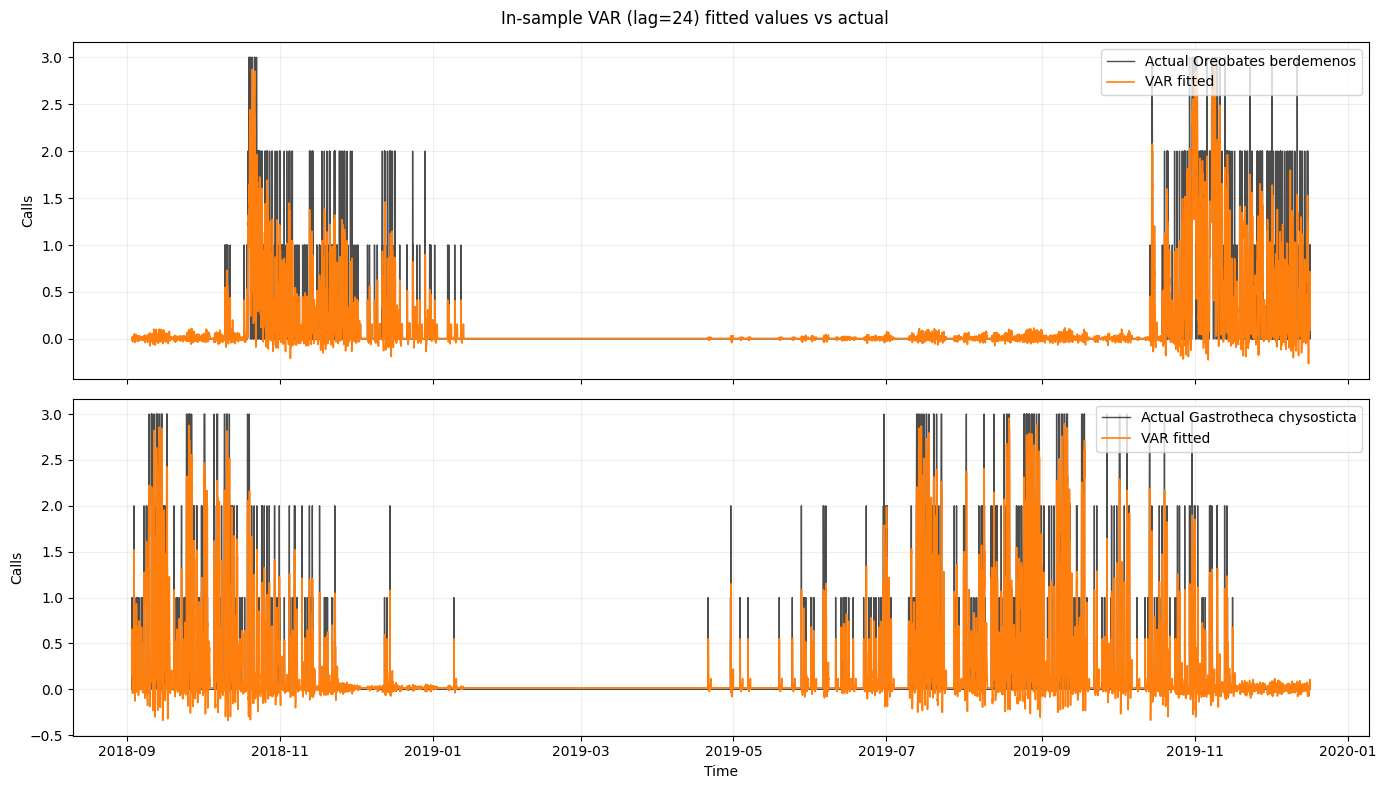

In-sample error metrics: {'Oreobates berdemenos': {'MAE': 0.11048957688229422, 'RMSE': 0.30409334971580476}, 'Gastrotheca chysosticta': {'MAE': 0.1425934602534056, 'RMSE': 0.34783844533892505}}


In [ ]:
from math import sqrt
import numpy as np

# Plot in-sample (fitted) VAR predictions vs actual counts for both species

# Ensure required objects exist
assert 'var_res' in globals(), "VAR model (var_res) not found. Run the VAR cell first."
assert 'df' in globals() and 'cols' in globals(), "Original dataframe and cols list required."

lag = var_res.k_ar
fitted = var_res.fittedvalues  # DataFrame with same column order as gc_data (cols)

# Actual data aligned to fitted index
actual = df[cols].loc[fitted.index]

# Quick sanity check
common_index = fitted.index.intersection(actual.index)
fitted = fitted.loc[common_index]
actual = actual.loc[common_index]

# Plot
fig_pred, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
for ax, species in zip(axes, cols):
    ax.plot(actual.index, actual[species], label=f'Actual {species}', color='black', linewidth=1, alpha=0.7)
    ax.plot(fitted.index, fitted[species], label='VAR fitted', color='tab:orange', linewidth=1.2)
    ax.set_ylabel('Calls')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.2)

axes[-1].set_xlabel('Time')
plt.suptitle(f'In-sample VAR (lag={lag}) fitted values vs actual')
plt.tight_layout()
plt.show()

# Optional simple accuracy metrics
metrics = {}
for species in cols:
    resid = actual[species] - fitted[species]
    metrics[species] = {
        'MAE': float(np.abs(resid).mean()),
        'RMSE': float(sqrt((resid**2).mean()))
    }
print("In-sample error metrics:", metrics)

Ordinal (ordered logit) in-sample error metrics: {'Gastrotheca chysosticta': {'MAE': 0.11485481960875422, 'RMSE': 0.3150035572799342}, 'Oreobates berdemenos': {'MAE': 0.09539871913597725, 'RMSE': 0.2897241594156374}}


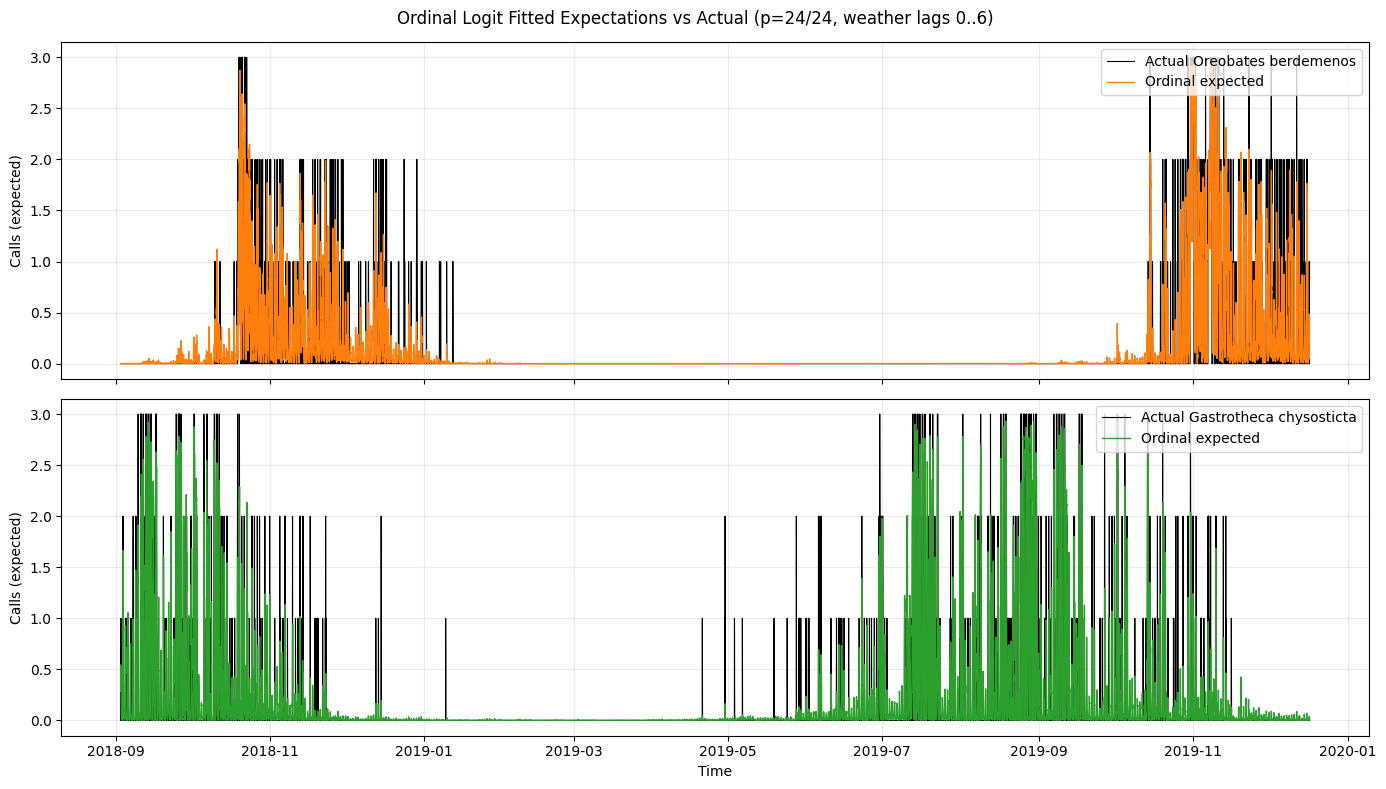

In [67]:
# Reconstruct and plot ordinal logistic (ordered logit) fitted expectations vs actual counts
# Uses the same feature engineering as in ordinal_granger_with_exog with selected p values.

# Settings recovered from previous run
gastro_col = "Gastrotheca chysosticta"
oreo_col = "Oreobates berdemenos"
temp_col = "Temp"
rh_col = "RH%"
p_gastro = results["Oreo_to_Gastro"]["selected_p"]
p_oreo = results["Gastro_to_Oreo"]["selected_p"]
s_exog = results["settings"]["weather_lag_span"]
distr = results["settings"]["link"]

# Base data (ensure sorting)
data = df[[gastro_col, oreo_col, temp_col, rh_col]].sort_index().copy()
data[gastro_col] = data[gastro_col].astype(int)
data[oreo_col] = data[oreo_col].astype(int)

# Add time + weather transforms (functions already defined earlier)
data = add_time_features(data)
data = zscore(data, [temp_col, rh_col])

# Build EXOG matrix (diurnal + weather lags 0..s_exog)
EXOG_parts = [data[["hour_sin", "hour_cos", "day_sin", "day_cos"]]]
for base in [temp_col + "_z", rh_col + "_z"]:
    cols_ex = {f"{base}_L0": data[base]}
    for L in range(1, s_exog + 1):
        cols_ex[f"{base}_L{L}"] = data[base].shift(L)
    EXOG_parts.append(pd.DataFrame(cols_ex, index=data.index))
EXOG = pd.concat(EXOG_parts, axis=1)

def fit_direction_predict(Y_name: str, X_name: str, p: int):
    """Fit ordered model for Y with its own and cross lags; return expected value series."""
    own_lags = make_lags(data, [Y_name], p)
    cross_lags = make_lags(data, [X_name], p)
    X_full = pd.concat([own_lags, cross_lags, EXOG], axis=1)
    endog = data[Y_name]

    mask = endog.notna() & X_full.notna().all(axis=1)
    y_f = endog[mask].astype(int)
    X_f = X_full[mask]

    model = OrderedModel(y_f, X_f, distr=distr)
    res = model.fit(method="lbfgs", maxiter=2000, disp=False)

    probs = res.predict(exog=X_f)  # (n, K)
    # Determine ordered category labels from observed y
    cats = np.sort(y_f.unique())
    # Expected value E[Y] = sum_k p_k * k
    exp_vals = (probs * cats).sum(axis=1)
    return exp_vals, y_f, res

# Fit both directions (each gives prediction for its Y)
gastro_exp, gastro_y, gastro_res = fit_direction_predict(gastro_col, oreo_col, p_gastro)
oreo_exp, oreo_y, oreo_res       = fit_direction_predict(oreo_col, gastro_col, p_oreo)

# Align predictions into single DataFrame
pred_index = gastro_exp.index.intersection(oreo_exp.index)
ordinal_pred = pd.DataFrame({
    f"{gastro_col}_pred": gastro_exp.loc[pred_index],
    f"{oreo_col}_pred": oreo_exp.loc[pred_index],
    gastro_col: data[gastro_col].loc[pred_index],
    oreo_col: data[oreo_col].loc[pred_index]
}, index=pred_index)

# Compute error metrics
ordinal_metrics = {}
for col, pred_col in [(gastro_col, f"{gastro_col}_pred"),
                      (oreo_col, f"{oreo_col}_pred")]:
    actual_vals = ordinal_pred[col]
    pred_vals = ordinal_pred[pred_col]
    resid_vals = actual_vals - pred_vals
    ordinal_metrics[col] = {
        "MAE": float(np.abs(resid_vals).mean()),
        "RMSE": float(np.sqrt((resid_vals**2).mean()))
    }

print("Ordinal (ordered logit) in-sample error metrics:", ordinal_metrics)

# Plot
fig_ord, axes_ord = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
for ax_plot, (col, pred_col, color) in zip(
    axes_ord,
    [(oreo_col, f"{oreo_col}_pred", "tab:orange"),
     (gastro_col, f"{gastro_col}_pred", "tab:green")]
):
    ax_plot.plot(ordinal_pred.index, ordinal_pred[col], label=f"Actual {col}", color="black", linewidth=0.8)
    ax_plot.plot(ordinal_pred.index, ordinal_pred[pred_col], label="Ordinal expected", color=color, linewidth=1.0)
    ax_plot.set_ylabel('Calls (expected)')
    ax_plot.legend(loc='upper right')
    ax_plot.grid(alpha=0.25)

axes_ord[-1].set_xlabel('Time')
plt.suptitle(f'Ordinal Logit Fitted Expectations vs Actual (p={p_oreo}/{p_gastro}, weather lags 0..{s_exog})')
plt.tight_layout()
plt.show()

# Store for later use
ordinal_predictions = ordinal_pred